Load train and validate datasets and concatenate them to do preprocessing on whole data

In [4]:
from __future__ import unicode_literals

import string
import numpy as np
import pandas as pd
!pip install hazm
from hazm import *
from gensim.models import Word2Vec
import codecs
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
import matplotlib.pyplot as plt

t = pd.read_csv('train.csv', delimiter='\t', index_col=0)
v = pd.read_csv('dev.csv', delimiter='\t', index_col=0)
train = t[['comment', 'label_id']].copy()
validate = v[['comment', 'label_id']].copy()
frames = [train, validate]
data = pd.concat(frames, ignore_index=True)

Convert all characters to lowercase

In [5]:
data['comment'] = data['comment'].apply(lambda x: ' '.join(x.lower() for x in x.split()))

Load stop words and delete stop words from dataset

In [6]:
nmz = Normalizer()
stops = sorted(
    list(set([nmz.normalize(w) for w in codecs.open('stopwords.dat', encoding='utf-8').read().split('\n') if w]))
)

data['comment'] = data['comment'].apply(lambda x: ' '.join(x for x in x.split() if x not in stops))

Lemmatize words in dataset

In [7]:
lemmatizer = Lemmatizer()
data['comment'] = data['comment'].apply(lambda x: ' '.join([lemmatizer.lemmatize(x) for x in x.split()]))

Define an iterator to iterate through sentences and fit Word2Vector model on sentences to get word vectors and word indexes

In [8]:
class SentenceIterator:
    def __init__(self, dataset):
        self.dataset = dataset

    def __iter__(self):
        for review in self.dataset.iloc[:, 0]:
            for sentence in review.split('.')[:-1]:
                words = [w for w in sentence.split(' ') if w != '']
                yield words


sentences = SentenceIterator(data)
w2v_model = Word2Vec(sentences=sentences)
w2v_model.train(sentences, epochs=10, total_examples=len(list(sentences)))
w2v_weights = w2v_model.wv.vectors
vocab_size, embedding_size = w2v_weights.shape

Tokenize words in each sentence to make sentences into integer sequences and define an iterator to iterate through sequences

In [9]:
def word2token(word):
    try:
        return w2v_model.wv.vocab[word].index
    # If word is not in index return 0. I realize this means that this
    # is the same as the word of index 0 (i.e. most frequent word), but 0s
    # will be padded later anyway by the embedding layer (which also
    # seems dirty, but I couldn't find a better solution right now)
    except KeyError:
        return 0


MAX_SEQUENCE_LENGTH = max([len(s) for s in list(sentences)])


class SequenceIterator:
    def __init__(self, dataset, seq_length):
        self.dataset = dataset

        self.translator = str.maketrans('', '', string.punctuation + '-')
        self.sentiments, self.ccount = np.unique(dataset.label_id, return_counts=True)

        self.seq_length = seq_length

    def __iter__(self):
        for comment, label_id in zip(self.dataset.iloc[:, 0], self.dataset.iloc[:, 1]):
            words = np.array([word2token(w) for w in comment.split(' ')[:self.seq_length] if w != ''])

            yield words, label_id


sequences = SequenceIterator(data, MAX_SEQUENCE_LENGTH)

Split dataset into X and Y and also train and validate datasets

In [10]:
set_x = []
set_y = []
for w, l in sequences:
    set_x.append(w)
    set_y.append(l)

set_x = pad_sequences(set_x, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
set_y = np.array(set_y)

x = set_x[:56700]
y = set_y[:56700]
val_x = set_x[56700:]
val_y = set_y[56700:]

Define the neural network model and add the appropriate layers, compile the model and print out the details

In [11]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    weights=[w2v_weights],
                    input_length=MAX_SEQUENCE_LENGTH,
                    mask_zero=True,
                    trainable=False))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 149, 100)          367700    
                                                                 
 bidirectional (Bidirectiona  (None, 200)              160800    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 528,701
Trainable params: 161,001
Non-trainable params: 367,700
_________________________________________________________________
None


Fit the model on the train dataset and validate them against the validate dataset

In [12]:
history = model.fit(x, y, epochs=5, batch_size=32,
                    validation_data=(val_x, val_y), verbose=1)

Epoch 1/5
1772/1772 [==============================] - 533s 290ms/step - loss: 0.3960 - accuracy: 0.8233 - val_loss: 0.3866 - val_accuracy: 0.8271
Epoch 2/5
1772/1772 [==============================] - 500s 282ms/step - loss: 0.3721 - accuracy: 0.8353 - val_loss: 0.3793 - val_accuracy: 0.8265
Epoch 3/5
1772/1772 [==============================] - 494s 279ms/step - loss: 0.3579 - accuracy: 0.8410 - val_loss: 0.3798 - val_accuracy: 0.8330
Epoch 4/5
1772/1772 [==============================] - 495s 279ms/step - loss: 0.3416 - accuracy: 0.8500 - val_loss: 0.3793 - val_accuracy: 0.8317
Epoch 5/5
1772/1772 [==============================] - 492s 278ms/step - loss: 0.3215 - accuracy: 0.8603 - val_loss: 0.3896 - val_accuracy: 0.8294


Plot train and validation loss and train and validation accuracy through epochs

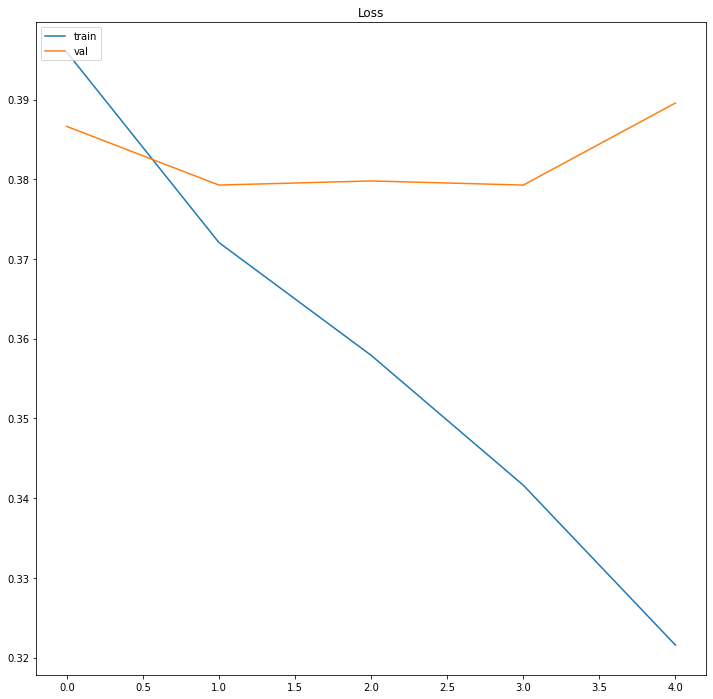

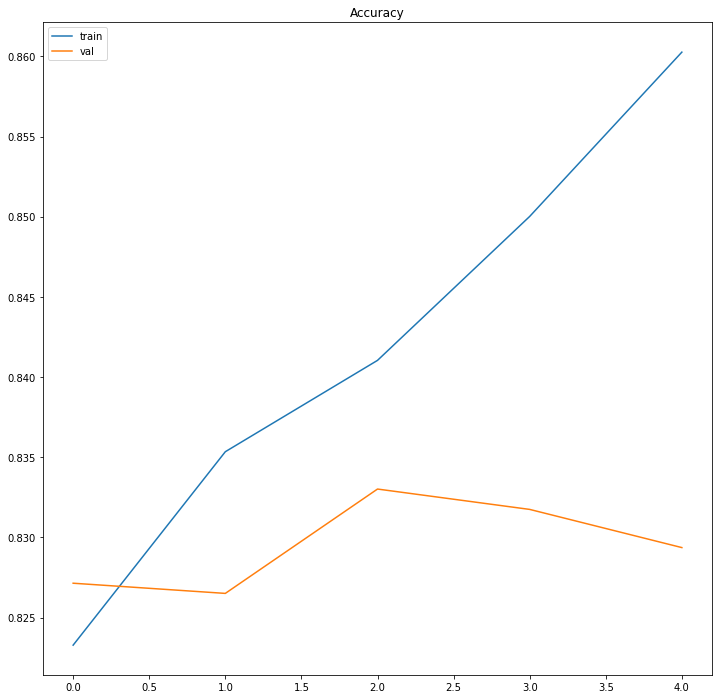

In [13]:
plt.figure(figsize=(12, 12))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(12, 12))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Predict sentiments using the model and print out the similarity between predicted sentiments and true sentiments

In [14]:
train_predictions = model.predict(x).tolist()
validate_predictions = model.predict(val_x).tolist()
train_predictions = list(map(lambda x: 0 if x[0] < 0.5 else 1, train_predictions))
validate_predictions = list(map(lambda x: 0 if x[0] < 0.5 else 1, validate_predictions))
train_standard = train['label_id'].tolist()
validate_standard = validate['label_id'].tolist()

train_identical = 0
train_length = min([len(train_predictions), len(train_standard)])
for i in range(train_length):
    if train_standard[i] == train_predictions[i]:
        train_identical += 1
print('Train dataset predictions similarity to source: ' + str(train_identical / train_length))

validate_identical = 0
validate_length = min([len(validate_predictions), len(validate_standard)])
for i in range(validate_length):
    if validate_standard[i] == validate_predictions[i]:
        validate_identical += 1
print('Validate dataset predictions similarity to source: ' + str(validate_identical / validate_length))

Train dataset predictions similarity to source: 0.8772663139329806
Validate dataset predictions similarity to source: 0.8293650793650794
